In [1]:
import MDAnalysis as mda
import numpy as np
import MDAnalysis.analysis.distances
import matplotlib.pyplot as plt
from numpy import linalg as LA
import MDAnalysis.analysis.rdf as rdf_calc
import seaborn as sns
import pandas as pd
from tqdm.auto import tqdm

# K26A_2980

In [2]:
u = mda.Universe("/Users/k20098771/Data/2024/CGtoAA/Startpoint/K26A_300us_298_0us/step6_6.gro", "/Users/k20098771/Data/2024/CGtoAA/Startpoint/K26A_300us_298_0us/step7_centered.xtc")
protein = u.select_atoms('protein')
print('There are {} residues in the protein'.format(len(protein.residues)))
#protein residues

There are 112 residues in the protein


In [3]:
#Trajectory frames
u_1000 = u.trajectory[::100]
len(u_1000)
time=[]
for ts in tqdm(u_1000):
    time.append(u.trajectory.time)
time=np.array(time)
len(time)

  0%|          | 0/61 [00:00<?, ?it/s]

61

In [4]:
#Select DAP12 and TREM2
DAP12_A = u.select_atoms('index 0:495 and name CA') #DAP12 chain A
DAP12_B = u.select_atoms('index 496:991 and name CA') #DAP12 chain B
TREM2 = u.select_atoms('index 992:1704 and name CA') #TREM2
print(np.unique(DAP12_A.resids))
print(np.unique(DAP12_B.resids))
print(np.unique(TREM2.resids))

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46]


In [5]:
# Create empty contact map
contact_map = np.zeros((len(TREM2.residues), len(DAP12_A.residues)), dtype=int)

for i, ts in enumerate(tqdm(u_1000)):
    # Create a temporary contact map for each time step
    temp_contact_map = np.zeros((len(TREM2.residues), len(DAP12_A.residues)), dtype=int)
    
    for j, trem_residue in enumerate(TREM2.residues):
        for k, dap_residue in enumerate(DAP12_A.residues):
            # Check if any pair of atoms between TREM2[j] and DAP12_A[k] is in contact
            contact_exists = any(
                MDAnalysis.analysis.distances.distance_array(
                    trem_atom.position,
                    dap_atom.position,
                    box=u.dimensions,
                ).min() < 3
                for trem_atom in trem_residue.atoms
                for dap_atom in dap_residue.atoms
            )
            # Increment the contact count if contact exists
            temp_contact_map[j, k] = int(contact_exists)
    
    # Add the temporary contact map to the cumulative contact map
    contact_map += temp_contact_map

# Now, 'contact_map' contains cumulative contact numbers between TREM2 and DAP12_A residues over multiple time steps.


  0%|          | 0/61 [00:00<?, ?it/s]

In [6]:
contact_map

array([[2, 0, 7, ..., 0, 0, 0],
       [3, 0, 6, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 1]])

In [7]:
contact_map_01 = contact_map
np.save('K26A_contact_map_01.npy', contact_map_01)
np.save('/Users/k20098771/Data/Figures/K26A_contact_map_01.npy', contact_map_01)
print("Saved contact_map as K26A_contact_map_01.npy")

Saved contact_map as K26A_contact_map_01.npy


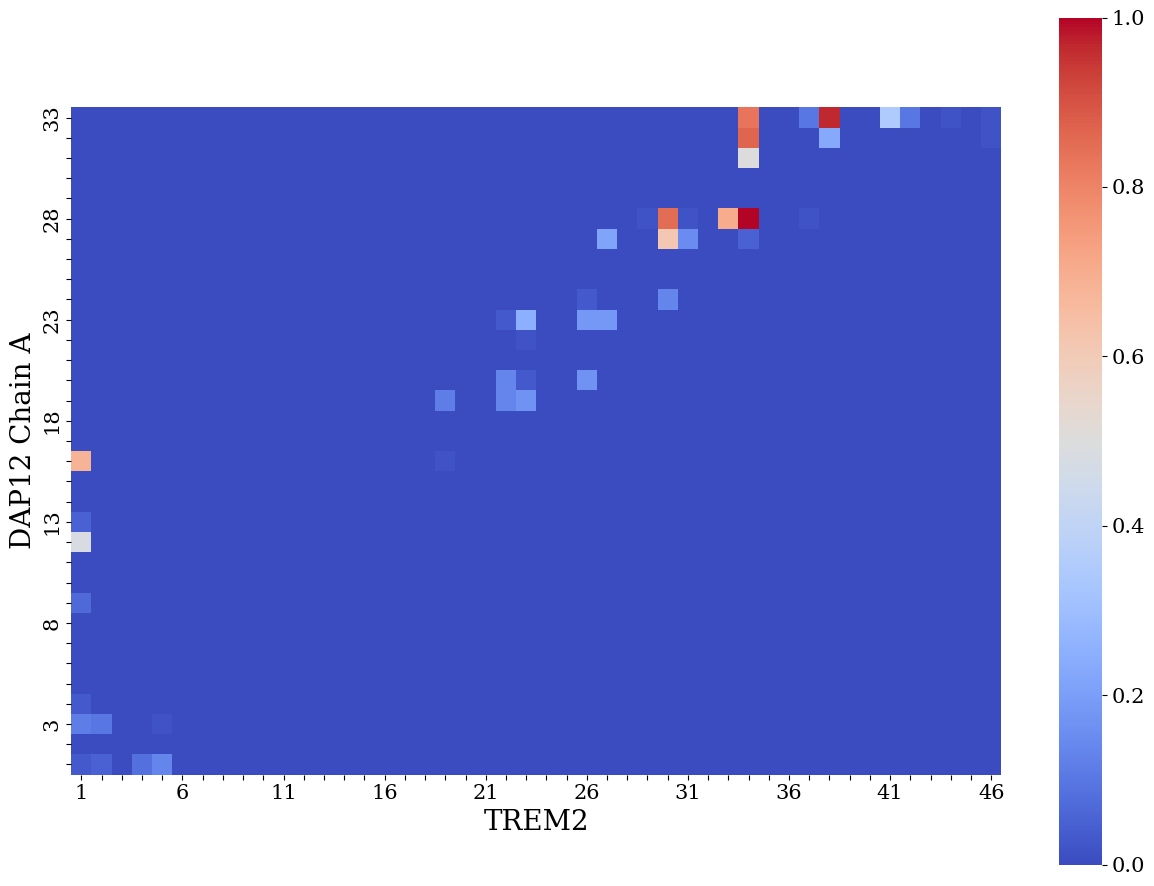

In [47]:
# Transpose the contact map (TREM2 rows, DAP12 columns → DAP12 rows, TREM2 columns)
contact_map_transposed_B = contact_map_01.T

# Reverse the order of DAP12 residues
reversed_dap12_residues = list(range(33, 0, -1))  # Reversed from 1 to 33
reversed_dap12_residues_array = np.array(reversed_dap12_residues)

# Reorder the contact map rows accordingly
contact_map_reordered = contact_map_transposed_B[reversed_dap12_residues_array - 1]  # Adjust for 0-based indexing

# Normalize the contact map to the range [0, 1]
contact_map_normalized = contact_map_reordered / np.max(contact_map_reordered)

# Plotting
plt.figure(figsize=(15, 11))
ax = sns.heatmap(
    contact_map_normalized,
    cmap="coolwarm",
    cbar=True,
    annot=False,
    square=True,
    vmin=0,  # Fix colorbar scale to start from 0
    vmax=1,  # and go to 1
    xticklabels=[str(label) if (idx - 1) % 5 == 0 else '' for idx, label in enumerate(TREM2.residues.resids, start=1)],
    yticklabels=[str(label) if (idx - 1) % 5 == 0 else '' for idx, label in enumerate(reversed_dap12_residues, start=1)],
)

# Customize the plot appearance
plt.xlabel("TREM2")
plt.ylabel("DAP12 Chain A")
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 15
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['axes.labelsize'] = 20

# Save the plot (optional)
plt.savefig("/Users/k20098771/Data/Figures/K26A_true_contact_map_01.png", dpi=600, format='png')

# Show the plot
plt.show()


In [16]:
# Create empty contact map
contact_map_B = np.zeros((len(TREM2.residues), len(DAP12_B.residues)), dtype=int)

for i, ts in enumerate(tqdm(u_1000)):
    # Create a temporary contact map for each time step
    temp_contact_map = np.zeros((len(TREM2.residues), len(DAP12_B.residues)), dtype=int)
    
    for j, trem_residue in enumerate(TREM2.residues):
        for k, dap_residue in enumerate(DAP12_B.residues):
            # Check if any pair of atoms between TREM2[j] and DAP12_B[k] is in contact
            contact_exists = any(
                MDAnalysis.analysis.distances.distance_array(
                    trem_atom.position,
                    dap_atom.position,
                    box=u.dimensions,
                ).min() < 3
                for trem_atom in trem_residue.atoms
                for dap_atom in dap_residue.atoms
            )
            # Increment the contact count if contact exists
            temp_contact_map[j, k] = int(contact_exists)
    
    # Add the temporary contact map to the cumulative contact map
    contact_map_B += temp_contact_map

# Now, 'contact_map' contains cumulative contact numbers between TREM2 and DAP12_A residues over multiple time steps.


  0%|          | 0/61 [00:00<?, ?it/s]

In [9]:
contact_map_B

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 2, 2],
       [0, 0, 0, ..., 0, 0, 2],
       [0, 0, 0, ..., 0, 0, 1]])

In [18]:
contact_map_02 = contact_map_B
np.save('K26A_contact_map_02.npy', contact_map_02)
np.save('/Users/k20098771/Data/Figures/K26A_contact_map_02.npy', contact_map_02)
print("Saved contact_map as K26A_contact_map_02.npy")

Saved contact_map as K26A_contact_map_02.npy


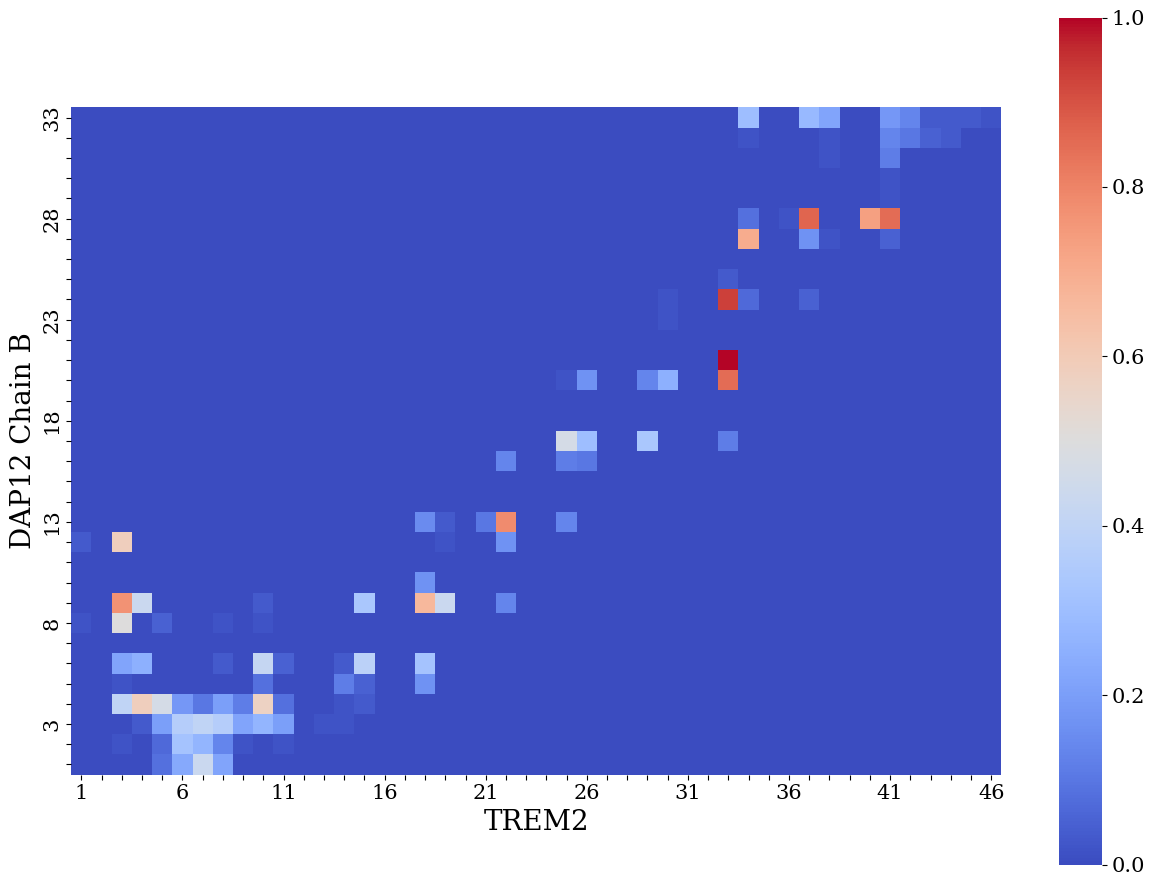

In [48]:
# Transpose the contact map (TREM2 rows, DAP12 columns → DAP12 rows, TREM2 columns)
contact_map_transposed_B = contact_map_02.T

# Reverse the order of DAP12 residues
reversed_dap12_residues = list(range(33, 0, -1))  # Reversed from 1 to 33
reversed_dap12_residues_array = np.array(reversed_dap12_residues)

# Reorder the contact map rows accordingly
contact_map_reordered = contact_map_transposed_B[reversed_dap12_residues_array - 1]  # Adjust for 0-based indexing

# Normalize the contact map to the range [0, 1]
contact_map_normalized = contact_map_reordered / np.max(contact_map_reordered)

# Plotting
plt.figure(figsize=(15, 11))
ax = sns.heatmap(
    contact_map_normalized,
    cmap="coolwarm",
    cbar=True,
    annot=False,
    square=True,
    vmin=0,  # Fix colorbar scale to start from 0
    vmax=1,  # and go to 1
    xticklabels=[str(label) if (idx - 1) % 5 == 0 else '' for idx, label in enumerate(TREM2.residues.resids, start=1)],
    yticklabels=[str(label) if (idx - 1) % 5 == 0 else '' for idx, label in enumerate(reversed_dap12_residues, start=1)],
)

# Customize the plot appearance
plt.xlabel("TREM2")
plt.ylabel("DAP12 Chain B")
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 15
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['axes.labelsize'] = 20

# Save the plot (optional)
plt.savefig("/Users/k20098771/Data/Figures/K26A_true_contact_map_02.png", dpi=600, format='png')

# Show the plot
plt.show()


# K26A_2900

In [20]:
u = mda.Universe("/Users/k20098771/Data/2024/CGtoAA/Startpoint/K26A_300us_290_0us/step6_6.gro", "/Users/k20098771/Data/2024/CGtoAA/Startpoint/K26A_300us_290_0us/step7_centered.xtc")
protein = u.select_atoms('protein')
print('There are {} residues in the protein'.format(len(protein.residues)))
#protein residues

There are 112 residues in the protein


In [21]:
#Trajectory frames
u_1000 = u.trajectory[::100]
len(u_1000)
time=[]
for ts in tqdm(u_1000):
    time.append(u.trajectory.time)
time=np.array(time)
len(time)

  0%|          | 0/61 [00:00<?, ?it/s]

61

In [22]:
#Select DAP12 and TREM2
DAP12_A = u.select_atoms('index 0:495 and name CA') #DAP12 chain A
DAP12_B = u.select_atoms('index 496:991 and name CA') #DAP12 chain B
TREM2 = u.select_atoms('index 992:1704 and name CA') #TREM2
print(np.unique(DAP12_A.resids))
print(np.unique(DAP12_B.resids))
print(np.unique(TREM2.resids))

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46]


In [23]:
# Create empty contact map
contact_map = np.zeros((len(TREM2.residues), len(DAP12_A.residues)), dtype=int)

for i, ts in enumerate(tqdm(u_1000)):
    # Create a temporary contact map for each time step
    temp_contact_map = np.zeros((len(TREM2.residues), len(DAP12_A.residues)), dtype=int)
    
    for j, trem_residue in enumerate(TREM2.residues):
        for k, dap_residue in enumerate(DAP12_A.residues):
            # Check if any pair of atoms between TREM2[j] and DAP12_A[k] is in contact
            contact_exists = any(
                MDAnalysis.analysis.distances.distance_array(
                    trem_atom.position,
                    dap_atom.position,
                    box=u.dimensions,
                ).min() < 3
                for trem_atom in trem_residue.atoms
                for dap_atom in dap_residue.atoms
            )
            # Increment the contact count if contact exists
            temp_contact_map[j, k] = int(contact_exists)
    
    # Add the temporary contact map to the cumulative contact map
    contact_map += temp_contact_map

# Now, 'contact_map' contains cumulative contact numbers between TREM2 and DAP12_A residues over multiple time steps.


  0%|          | 0/61 [00:00<?, ?it/s]

In [24]:
contact_map

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [25]:
contact_map_03 = contact_map
np.save('K26A_contact_map_03.npy', contact_map_03)
np.save('/Users/k20098771/Data/Figures/K26A_contact_map_03.npy', contact_map_03)
print("Saved contact_map as K26A_2900_contact_map_03.npy")

Saved contact_map as K26A_2900_contact_map_03.npy


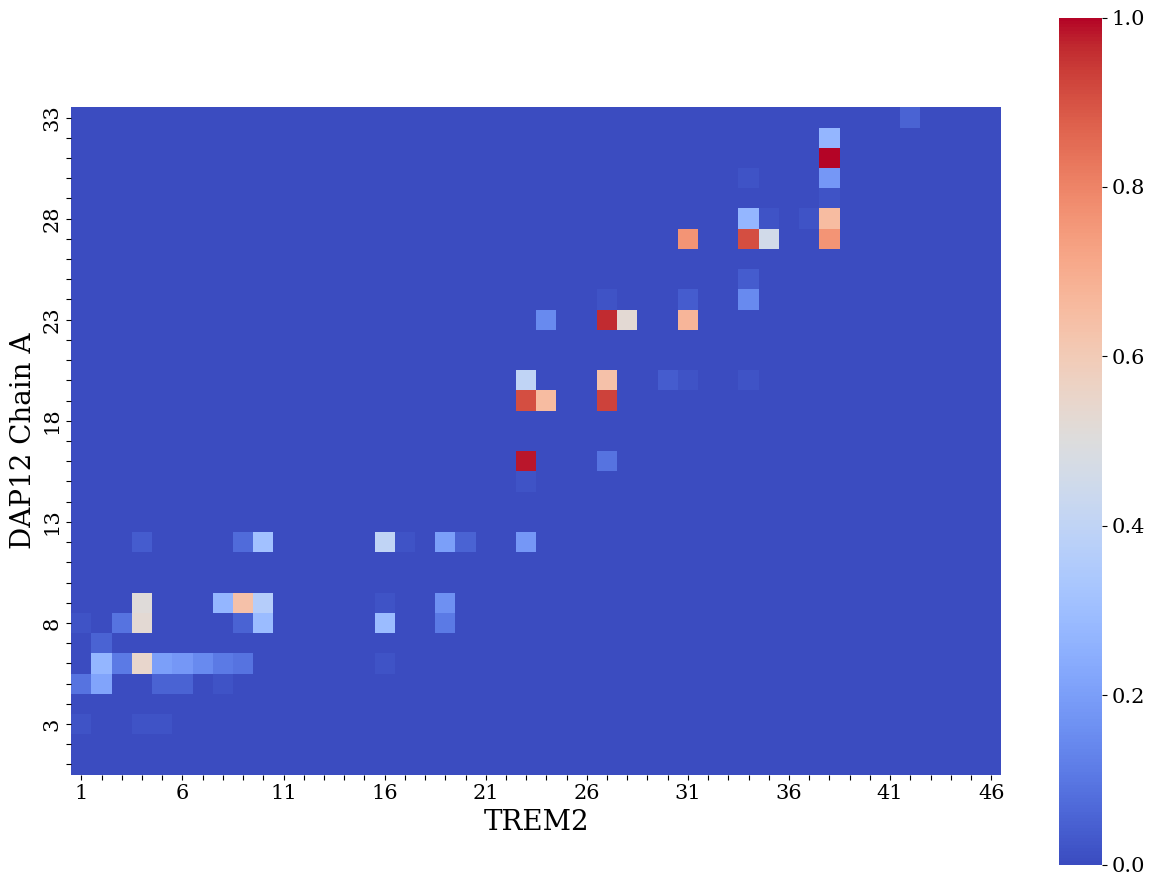

In [55]:
# Transpose the contact map (TREM2 rows, DAP12 columns → DAP12 rows, TREM2 columns)
contact_map_transposed_B = contact_map_03.T

# Reverse the order of DAP12 residues
reversed_dap12_residues = list(range(33, 0, -1))  # Reversed from 1 to 33
reversed_dap12_residues_array = np.array(reversed_dap12_residues)

# Reorder the contact map rows accordingly
contact_map_reordered = contact_map_transposed_B[reversed_dap12_residues_array - 1]  # Adjust for 0-based indexing

# Normalize the contact map to the range [0, 1]
contact_map_normalized = contact_map_reordered / np.max(contact_map_reordered)

# Plotting
plt.figure(figsize=(15, 11))
ax = sns.heatmap(
    contact_map_normalized,
    cmap="coolwarm",
    cbar=True,
    annot=False,
    square=True,
    vmin=0,  # Fix colorbar scale to start from 0
    vmax=1,  # and go to 1
    xticklabels=[str(label) if (idx - 1) % 5 == 0 else '' for idx, label in enumerate(TREM2.residues.resids, start=1)],
    yticklabels=[str(label) if (idx - 1) % 5 == 0 else '' for idx, label in enumerate(reversed_dap12_residues, start=1)],
)

# Customize the plot appearance
plt.xlabel("TREM2")
plt.ylabel("DAP12 Chain A")
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 15
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['axes.labelsize'] = 20

# Save the plot (optional)
plt.savefig("/Users/k20098771/Data/Figures/K26A_side_chainB_contact_map_03.png", dpi=600, format='png')

# Show the plot
plt.show()


In [27]:
# Create empty contact map
contact_map_B = np.zeros((len(TREM2.residues), len(DAP12_B.residues)), dtype=int)

for i, ts in enumerate(tqdm(u_1000)):
    # Create a temporary contact map for each time step
    temp_contact_map = np.zeros((len(TREM2.residues), len(DAP12_B.residues)), dtype=int)
    
    for j, trem_residue in enumerate(TREM2.residues):
        for k, dap_residue in enumerate(DAP12_B.residues):
            # Check if any pair of atoms between TREM2[j] and DAP12_B[k] is in contact
            contact_exists = any(
                MDAnalysis.analysis.distances.distance_array(
                    trem_atom.position,
                    dap_atom.position,
                    box=u.dimensions,
                ).min() < 3
                for trem_atom in trem_residue.atoms
                for dap_atom in dap_residue.atoms
            )
            # Increment the contact count if contact exists
            temp_contact_map[j, k] = int(contact_exists)
    
    # Add the temporary contact map to the cumulative contact map
    contact_map_B += temp_contact_map

# Now, 'contact_map' contains cumulative contact numbers between TREM2 and DAP12_A residues over multiple time steps.


  0%|          | 0/61 [00:00<?, ?it/s]

In [28]:
contact_map_B

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 2, 0]])

In [29]:
contact_map_04 = contact_map_B
np.save('K26A_contact_map_04.npy', contact_map_04)
np.save('/Users/k20098771/Data/Figures/K26A_contact_map_04.npy', contact_map_04)
print("Saved contact_map as K26A_contact_map_04.npy")

Saved contact_map as K26A_contact_map_04.npy


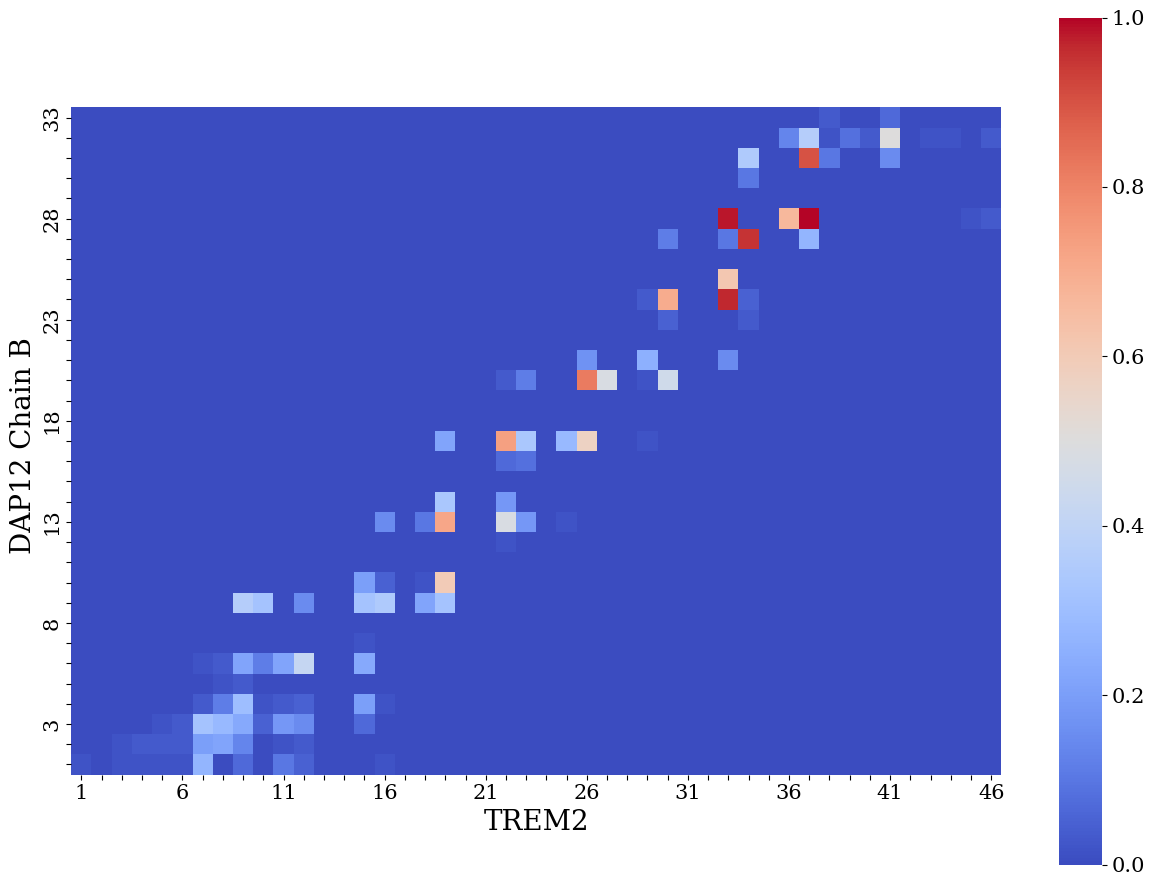

In [54]:
# Transpose the contact map (TREM2 rows, DAP12 columns → DAP12 rows, TREM2 columns)
contact_map_transposed_B = contact_map_04.T

# Reverse the order of DAP12 residues
reversed_dap12_residues = list(range(33, 0, -1))  # Reversed from 1 to 33
reversed_dap12_residues_array = np.array(reversed_dap12_residues)

# Reorder the contact map rows accordingly
contact_map_reordered = contact_map_transposed_B[reversed_dap12_residues_array - 1]  # Adjust for 0-based indexing

# Normalize the contact map to the range [0, 1]
contact_map_normalized = contact_map_reordered / np.max(contact_map_reordered)

# Plotting
plt.figure(figsize=(15, 11))
ax = sns.heatmap(
    contact_map_normalized,
    cmap="coolwarm",
    cbar=True,
    annot=False,
    square=True,
    vmin=0,  # Fix colorbar scale to start from 0
    vmax=1,  # and go to 1
    xticklabels=[str(label) if (idx - 1) % 5 == 0 else '' for idx, label in enumerate(TREM2.residues.resids, start=1)],
    yticklabels=[str(label) if (idx - 1) % 5 == 0 else '' for idx, label in enumerate(reversed_dap12_residues, start=1)],
)

# Customize the plot appearance
plt.xlabel("TREM2")
plt.ylabel("DAP12 Chain B ")
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 15
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['axes.labelsize'] = 20

# Save the plot (optional)
plt.savefig("/Users/k20098771/Data/Figures/K26A_side_chainB_contact_map_04.png", dpi=800, format='png')

# Show the plot
plt.show()


# K26A_2950

In [31]:
u = mda.Universe("/Users/k20098771/Data/2024/CGtoAA/Startpoint/K26A_300us_295_0us/step6_6.gro", "/Users/k20098771/Data/2024/CGtoAA/Startpoint/K26A_300us_295_0us/step7_centered.xtc")
protein = u.select_atoms('protein')
print('There are {} residues in the protein'.format(len(protein.residues)))
#protein residues

There are 112 residues in the protein


In [32]:
#Trajectory frames
u_1000 = u.trajectory[::100]
len(u_1000)
time=[]
for ts in tqdm(u_1000):
    time.append(u.trajectory.time)
time=np.array(time)
len(time)

  0%|          | 0/61 [00:00<?, ?it/s]

61

In [33]:
#Select DAP12 and TREM2
DAP12_A = u.select_atoms('index 0:495 and name CA') #DAP12 chain A
DAP12_B = u.select_atoms('index 496:991 and name CA') #DAP12 chain B
TREM2 = u.select_atoms('index 992:1704 and name CA') #TREM2
print(np.unique(DAP12_A.resids))
print(np.unique(DAP12_B.resids))
print(np.unique(TREM2.resids))

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46]


In [34]:
# Create empty contact map
contact_map = np.zeros((len(TREM2.residues), len(DAP12_A.residues)), dtype=int)

for i, ts in enumerate(tqdm(u_1000)):
    # Create a temporary contact map for each time step
    temp_contact_map = np.zeros((len(TREM2.residues), len(DAP12_A.residues)), dtype=int)
    
    for j, trem_residue in enumerate(TREM2.residues):
        for k, dap_residue in enumerate(DAP12_A.residues):
            # Check if any pair of atoms between TREM2[j] and DAP12_A[k] is in contact
            contact_exists = any(
                MDAnalysis.analysis.distances.distance_array(
                    trem_atom.position,
                    dap_atom.position,
                    box=u.dimensions,
                ).min() < 3
                for trem_atom in trem_residue.atoms
                for dap_atom in dap_residue.atoms
            )
            # Increment the contact count if contact exists
            temp_contact_map[j, k] = int(contact_exists)
    
    # Add the temporary contact map to the cumulative contact map
    contact_map += temp_contact_map

# Now, 'contact_map' contains cumulative contact numbers between TREM2 and DAP12_A residues over multiple time steps.


  0%|          | 0/61 [00:00<?, ?it/s]

In [35]:
contact_map

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 3]])

In [36]:
contact_map_05 = contact_map
np.save('K26A_contact_map_05.npy', contact_map_05)
np.save('/Users/k20098771/Data/Figures/K26A_contact_map_05.npy', contact_map_05)
print("Saved contact_map as K26A_contact_map_05.npy")

Saved contact_map as K26A_contact_map_05.npy


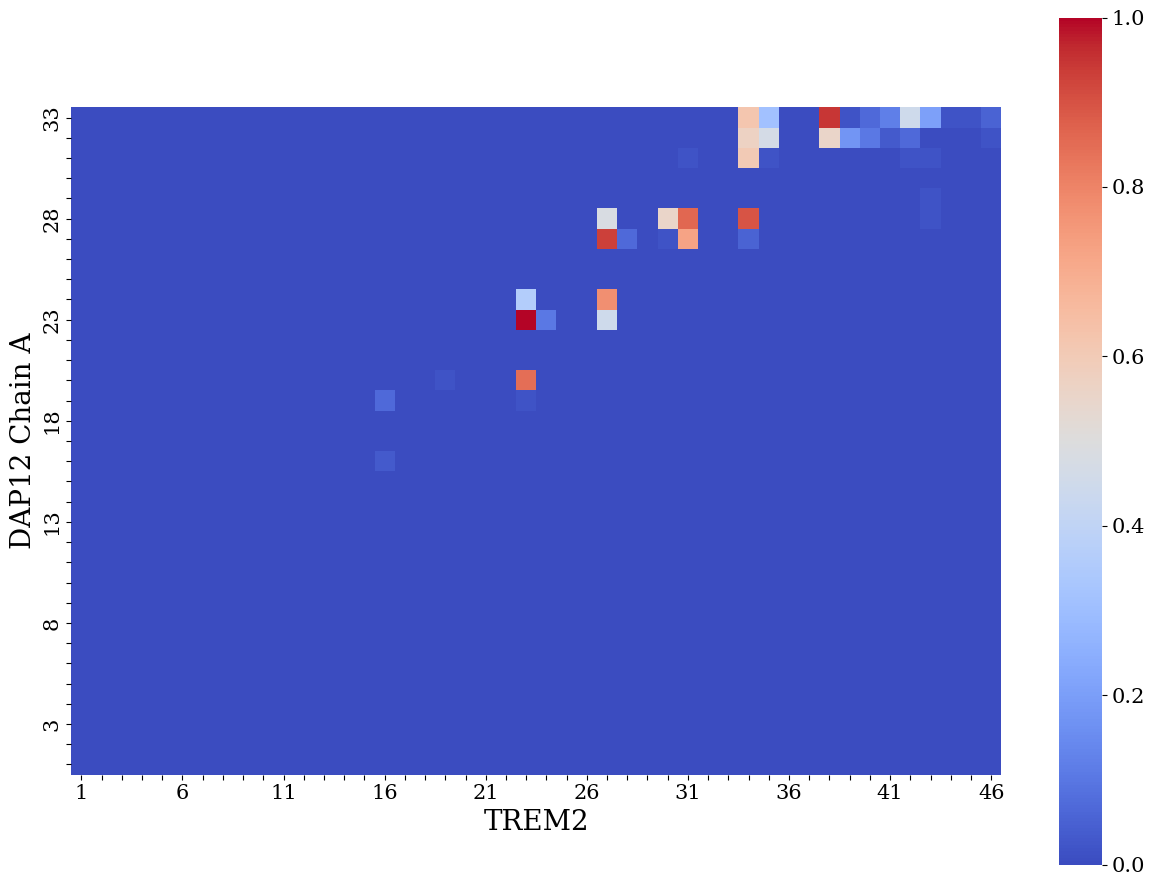

In [56]:
# Transpose the contact map (TREM2 rows, DAP12 columns → DAP12 rows, TREM2 columns)
contact_map_transposed_B = contact_map_05.T

# Reverse the order of DAP12 residues
reversed_dap12_residues = list(range(33, 0, -1))  # Reversed from 1 to 33
reversed_dap12_residues_array = np.array(reversed_dap12_residues)

# Reorder the contact map rows accordingly
contact_map_reordered = contact_map_transposed_B[reversed_dap12_residues_array - 1]  # Adjust for 0-based indexing

# Normalize the contact map to the range [0, 1]
contact_map_normalized = contact_map_reordered / np.max(contact_map_reordered)

# Plotting
plt.figure(figsize=(15, 11))
ax = sns.heatmap(
    contact_map_normalized,
    cmap="coolwarm",
    cbar=True,
    annot=False,
    square=True,
    vmin=0,  # Fix colorbar scale to start from 0
    vmax=1,  # and go to 1
    xticklabels=[str(label) if (idx - 1) % 5 == 0 else '' for idx, label in enumerate(TREM2.residues.resids, start=1)],
    yticklabels=[str(label) if (idx - 1) % 5 == 0 else '' for idx, label in enumerate(reversed_dap12_residues, start=1)],
)

# Customize the plot appearance
plt.xlabel("TREM2")
plt.ylabel("DAP12 Chain A")
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 15
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['axes.labelsize'] = 20

# Save the plot (optional)
plt.savefig("/Users/k20098771/Data/Figures/K26A_side_chainB_contact_map_05.png", dpi=800, format='png')

# Show the plot
plt.show()


In [38]:
# Create empty contact map
contact_map_B = np.zeros((len(TREM2.residues), len(DAP12_B.residues)), dtype=int)

for i, ts in enumerate(tqdm(u_1000)):
    # Create a temporary contact map for each time step
    temp_contact_map = np.zeros((len(TREM2.residues), len(DAP12_B.residues)), dtype=int)
    
    for j, trem_residue in enumerate(TREM2.residues):
        for k, dap_residue in enumerate(DAP12_B.residues):
            # Check if any pair of atoms between TREM2[j] and DAP12_B[k] is in contact
            contact_exists = any(
                MDAnalysis.analysis.distances.distance_array(
                    trem_atom.position,
                    dap_atom.position,
                    box=u.dimensions,
                ).min() < 3
                for trem_atom in trem_residue.atoms
                for dap_atom in dap_residue.atoms
            )
            # Increment the contact count if contact exists
            temp_contact_map[j, k] = int(contact_exists)
    
    # Add the temporary contact map to the cumulative contact map
    contact_map_B += temp_contact_map

# Now, 'contact_map' contains cumulative contact numbers between TREM2 and DAP12_A residues over multiple time steps.


  0%|          | 0/61 [00:00<?, ?it/s]

In [39]:
contact_map_B

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 2],
       [0, 0, 0, ..., 0, 1, 2]])

In [40]:
contact_map_06 = contact_map_B
np.save('K26A_contact_map_06.npy', contact_map_06)
np.save('/Users/k20098771/Data/Figures/K26A_contact_map_06.npy', contact_map_06)
print("Saved contact_map as K26A_contact_map_06.npy")

Saved contact_map as K26A_contact_map_06.npy


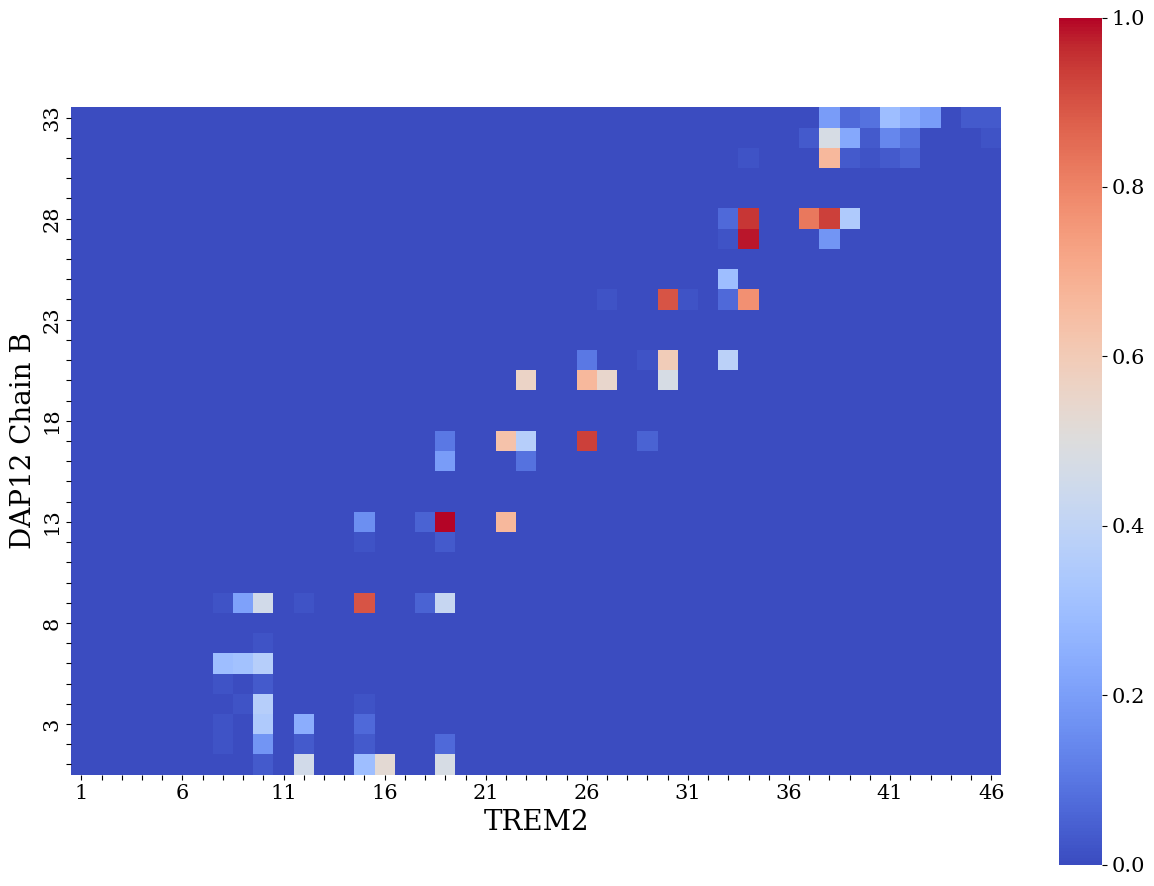

In [57]:
# Transpose the contact map (TREM2 rows, DAP12 columns → DAP12 rows, TREM2 columns)
contact_map_transposed_B = contact_map_06.T

# Reverse the order of DAP12 residues
reversed_dap12_residues = list(range(33, 0, -1))  # Reversed from 1 to 33
reversed_dap12_residues_array = np.array(reversed_dap12_residues)

# Reorder the contact map rows accordingly
contact_map_reordered = contact_map_transposed_B[reversed_dap12_residues_array - 1]  # Adjust for 0-based indexing

# Normalize the contact map to the range [0, 1]
contact_map_normalized = contact_map_reordered / np.max(contact_map_reordered)

# Plotting
plt.figure(figsize=(15, 11))
ax = sns.heatmap(
    contact_map_normalized,
    cmap="coolwarm",
    cbar=True,
    annot=False,
    square=True,
    vmin=0,  # Fix colorbar scale to start from 0
    vmax=1,  # and go to 1
    xticklabels=[str(label) if (idx - 1) % 5 == 0 else '' for idx, label in enumerate(TREM2.residues.resids, start=1)],
    yticklabels=[str(label) if (idx - 1) % 5 == 0 else '' for idx, label in enumerate(reversed_dap12_residues, start=1)],
)

# Customize the plot appearance
plt.xlabel("TREM2")
plt.ylabel("DAP12 Chain B")
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 15
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['axes.labelsize'] = 20

# Save the plot (optional)
plt.savefig("/Users/k20098771/Data/Figures/K26A_side_chainB_contact_map_06.png", dpi=800, format='png')

# Show the plot
plt.show()


In [58]:
np.max(contact_map_reordered)

57

# Mix all

In [29]:
# Load all six contact maps
contact_maps = [np.load(f'K26A_contact_map_0{i}.npy') for i in range(1, 7)]

# Sum them element-wise to get the merged contact map
merged_contact_map = np.sum(contact_maps, axis=0)

# Save the merged contact map
np.save('merged_contact_map.npy', merged_contact_map)

np.savetxt('/Users/k20098771/Data/Figures/K26A_contact_map_merged.npy', merged_contact_map, fmt='%d')
print("Saved contact_map as K26A_contact_map_merged.npy")

# Optionally, print the shape to verify
print("Merged contact map shape:", merged_contact_map.shape)

print(merged_contact_map)

Saved contact_map as K26A_contact_map_merged.npy
Merged contact map shape: (46, 33)
[[3 0 8 ... 0 0 0]
 [3 0 6 ... 0 0 0]
 [1 2 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 3 4]
 [0 0 0 ... 0 0 5]
 [0 0 0 ... 0 5 7]]


In [36]:
prob=merged_contact_map/(len(u_1000)*3)
chart=np.where(prob>=0.6)

In [31]:
df = pd.DataFrame(chart)
index=["TREM2", "DAP12_B"]
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
df

,0,1,2,3,4,5,6
0,21,22,32,33,33,36,37
1,12,19,23,26,27,27,32


In [32]:
df = pd.DataFrame({'TREM2': chart[0]+161})
df['DAP12'] = chart[1]+35 # Add a column 'D' with values from chartA[1]
#df.index = range(1, len(df) + 1)
print(df)

   TREM2  DAP12
0    182     47
1    183     54
2    193     58
3    194     61
4    194     62
5    197     62
6    198     67


In [33]:
# Save as CSV
df.to_csv("/Users/k20098771/Data/Figures/K26A_contacts_60_percentage.csv", index=False)

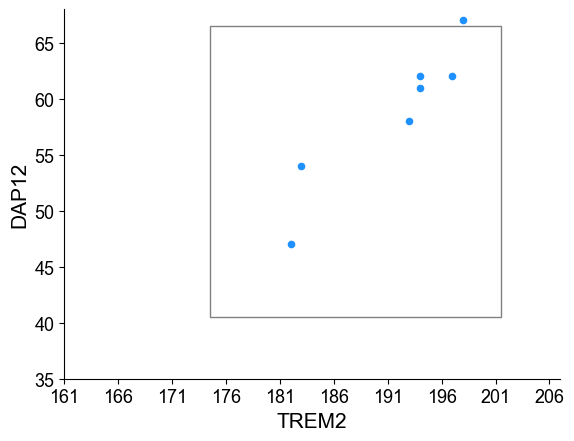

In [35]:
import matplotlib.patches as patches

df = pd.DataFrame({'TREM2': chart[0]+161})
df['DAP12'] = chart[1]+35

# Plotting the DataFrame
ax = df.plot(x='TREM2', y='DAP12', kind='scatter', color='dodgerblue')
ax.set_xlabel('TREM2', fontsize=15, fontname='Arial')
ax.set_ylabel('DAP12', fontsize=15, fontname='Arial')

# Add the rectangle
#rect = patches.Rectangle((25.5, 16.5), width=1, height=5, fill=False, edgecolor='red') #DxxxT
#ax.add_patch(rect)

rect_2 = patches.Rectangle((13.5+161, 5.5+35), width=27, height=26, fill=False, edgecolor='gray')
ax.add_patch(rect_2)

# Adjusting the x-axis ticks
x_ticks = np.arange(161, 46+161, 5)
y_ticks = np.arange(35, 33+35, 5)
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)
plt.xlim([0+161,46+161])
plt.ylim([0+35,33+35])

# Changing the font name of x-axis and y-axis tick labels
ax.set_xticklabels(ax.get_xticks(), fontsize=13, fontname='Arial')
ax.set_yticklabels(ax.get_yticks(), fontsize=13, fontname='Arial')

ax=plt.gca() ##get caurrent axis
ax.spines["right"].set_color("none") #visible for right spines
ax.spines["top"].set_color("none") ##visible for top spines

#Saving the plot as an image file
plt.savefig("/Users/k20098771/Data/Figures/K26A_contact_map_merged_60.eps", dpi=800, format='eps',bbox_inches="tight")
